<a href="https://colab.research.google.com/github/jeffrey96158/108062219_project3/blob/master/Vertical_Federated_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Package

In [65]:
# pytorch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.datasets as dset 
import torchvision.transforms as transforms
import torch.utils.data as data

# others
from tqdm.notebook import tqdm as tqdm
import argparse
from sklearn.metrics import f1_score
import random

import matplotlib.pyplot as plt
import numpy as np

# Download Dataset (MNIST)
MNIST is a data set of handwrite number

In [66]:
trans = transforms.Compose([transforms.ToTensor()]) 
train_set = dset.MNIST(root='.', train=True, download=True ,transform=trans)
test_set = dset.MNIST(root='.', train=False,transform=trans)

# Arguments

In [67]:
parser = argparse.ArgumentParser(description='FL with PyTorch MNIST')
parser.add_argument('--no-cuda', action='store_true', default=False, 
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=50, metavar='S',
                    help='random seed (default: 50)')
parser.add_argument('--epochs', type=int, default=1, metavar='N',
                    help='number of epochs to train (default: 1)')
parser.add_argument('--lr', type=float, default=0.1, metavar='LR',
                    help='learning rate (default: 0.1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--batch-size', type=int, default=50, metavar='N',
                    help='input batch size for training (default: 50)')
parser.add_argument('--test-batch-size', type=int, default=50, metavar='N',
                    help='input batch size for testing (default: 50)')
parser.add_argument('--num-participants', type=int, default=10, metavar='NP',
                    help='number of participants (default: 10)')
parser.add_argument('--randomorder_rounds', type=int, default=1, metavar='NP',
                    help='rounds for Random Order (default: 1)')
parser.add_argument('--asynchronous_rounds', type=int, default=1, metavar='NP',
                    help='rounds for Asynchronous (default: 1)')
args = parser.parse_args(args=[])

# Class Definition

In [68]:
## Initialization
# Control Seed
# CUDA is a GPU core for parrallel computing
torch.manual_seed(args.seed)

# Select Device
use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else 'cpu')

if use_cuda:
    print("Using CUDA!")
    torch.cuda.manual_seed(args.seed)
else:
    print('Not using CUDA!!!')

Using CUDA!


# Network
- Split the network into client_network and server_network
- client_network and server_network get half of the module.

In [69]:
#使用linear regression model
#連續使用3次linear regression
class network(nn.Module):
    def __init__(self):
        super(network,self).__init__()
        self.L1 = nn.Linear(784,128)
        self.L2 = nn.Linear(128,64)
        self.output = nn.Linear(64,10)
    def forward(self , x):
        x = F.relu(self.L1(x))
        x = F.relu(self.L2(x))
        x = self.output(x)  #若是loss用crossentropy 他最後一層會自己用softmax
        return x
        
class client_network(nn.Module):
    def __init__(self):
        super(client_network,self).__init__()
        self.L1 = nn.Linear(784,128)
        self.L2 = nn.Linear(128,64)
    def forward(self , x):
        x = F.relu(self.L1(x))
        x = F.relu(self.L2(x))
        return x

class server_network(nn.Module):
    def __init__(self, num):
        super(server_network,self).__init__()
        self.output = nn.Linear(64*num,10)
    def forward(self, x):
        x = self.output(x)  #若是loss用crossentropy 他最後一層會自己用softmax
        return x

#Client

In [70]:
class Participant():
    def __init__(self):
        global device
        self.local_network = client_network().to(device)
        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = args.lr
        self.optimizer = torch.optim.SGD(params=self.local_network.parameters(torch.tensor(1.0, requires_grad=True)), lr = self.lr)
        self.loss_history = []
        self.testloss_history = []
        self.accu_history = []
        self.gradient_buffer = dict() # download grandient_buffer
    def Upload(self, net_out, GlobalServer):
        GlobalServer.ServerFP(net_out)
    
    def Download(self, GlobalServer):# Download parameters from server
        self.local_network.load_state_dict(GlobalServer.global_network.state_dict()) 
    
    def LocalTraining(self, train_dataset, GlobalServer, epochs = 1, DownUp_cmd = "DU"):
        for e in range(epochs):
            epoch_loss_sum = 0
            pbar = tqdm(enumerate(train_dataset), total=len(train_dataset))
            for batch_idx, (data, label) in pbar:
                # same as HFL
                data, label = data.to(device), label.to(device)
                batch_size = data.shape[0]
                data = data.view(batch_size,-1) # 把data tensor的shape做改變
                net_out = self.local_network(data) # 把x丟進net去train，得到output
                # from here, upload the parameter to server.
                self.Upload(net_out, GlobalServer) # upload {netout} to {server}.
                # global server will calculate the gradient.
                self.Download(GlobalServer) # Download {gradient} from {server} (store in gradient_buffer)
                self.AddGradient() # there's no Participant().AddGradient()
                # same as HFL
                if (batch_idx+1) % args.log_interval == 0:
                    done = (batch_idx+1) * len(data)
                    percentage = 100. * (batch_idx+1) / len(train_dataset)
                    pbar.set_description(f'Train Epoch: {e} [{done:5}/{len(train_dataset.dataset)} ({percentage:3.0f}%)]')
    def LocalTrain(self,data):
      net_out = self.local_network(data)
      return net_out
    def LocalTesting(self, test_dataset):# same as HFL
        self.local_network.eval()
        correct = 0
        epoch_loss_sum = 0
        Labels = []
        Predicts = []
        with torch.no_grad():
            for data, label in test_dataset:
                data, label = data.to(device), label.to(device)
                batchsize = data.shape[0]
                data = data.view(batchsize, -1)
                net_out = self.local_network(data)
                loss = self.loss_fn(net_out, label)
                epoch_loss_sum += float(loss.item())

                predict = net_out.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
                correct += predict.eq(label.data.view_as(predict)).sum().item()
                Labels = Labels + label.tolist()
                Predicts = Predicts + predict.tolist()

            epoch_loss_sum /= len(test_dataset.dataset)
            accuracy = 100. * correct / len(test_dataset.dataset)
            self.testloss_history.append(epoch_loss_sum)
            self.accu_history.append(accuracy / 100)
            f1 = f1_score(Labels, Predicts, average = "macro")
            print(f'Test set: Average loss: {epoch_loss_sum:.4f}, Accuracy: {correct}/{len(test_dataset.dataset)} ({accuracy:.2f}%), F1-score: {f1:.4f}')



#Server

In [71]:
class GlobalServer():
    def __init__(self,num):
        global device
        self.global_network = server_network(num).to(device)
        self.gradient_buffer = dict()
        self.temp_gradient_buffer = dict()
        self.loss_history = []
        self.lr = args.lr
        self.optimizer = torch.optim.SGD(params=self.global_network.parameters(torch.tensor(1.0, requires_grad=True)), lr = self.lr)
        self.loss_fn = nn.CrossEntropyLoss()
        # GlobalServer set a dict to preserve net_out
        self.net_out_buffer = dict()
        self.label_buffer = dict()
    def AddGradient(self):
        state_dict_tmp = self.global_network.state_dict()
        for key in state_dict_tmp.keys():
            state_dict_tmp[key] += self.gradient_buffer[key]
        self.temp_gradient_buffer = self.gradient_buffer.copy()
        self.global_network.load_state_dict(state_dict_tmp)
        self.gradient_buffer.clear()
    def Append_loss(self, loss_sum):
        self.loss_history.append(loss_sum)

    def ServerFP(self, net_out):
        label = label.to(device)
        server_out = self.global_network(net_out)
        loss = self.loss_fn(net_out,label)
        self.optimizer.zero_grad() # clear gradient
        loss.backward() # back propagation
        #opt.step() # parameter update
        # for layer, param in zip(ln.state_dict().keys(), ln.parameters()):
        #   if (self.gradient_buffer.get(layer) == None): 
        #     self.gradient_buffer[layer] = -1 * param.grad * self.lr
        #   else:
        #     self.gradient_buffer[layer] -= param.grad * self.lr
        self.AddGradient();
    def ServerTrain(self,net_in):
      net_out = self.global_network(net_in)
      return net_out

#SplitData

In [72]:
def GenerateParticipant(num = 1):
    P_dict = dict()
    for i in range(num):
        s = 'P'
        s = s + str(i)
        P_dict[s] = Participant()

    return P_dict

# TrainSet_list[num], TestSet_list[num] -> store the name
# TrainDataSet_dict[num], TestDataSet_dict[num] -> store the data
def SplitData(train_set, test_set, num):
    if len(train_set) % num or len(test_set) % num:
        print(f"len(train_set):{len(train_set)}, len(test_set):{len(test_set)}, can not be indivisible by {num}")
        return
    
    train_split = int(len(train_set) / num)
    test_split = int(len(test_set) / num)

    portions = [train_split] * num
    TrainSet_list = [None] * num
    TrainSet_list = data.random_split(train_set, portions)

    portions = [test_split] * num
    TestSet_list = [None] * num
    TestSet_list = data.random_split(test_set, portions)

    TrainDataSet_dict = dict()
    TestDataSet_dict = dict()

    # mini batch
    for i in range(num):
        s = 'P'
        s = s + str(i)
        TrainDataSet_dict[s] = data.DataLoader(dataset =  TrainSet_list[i], batch_size=args.batch_size, shuffle=True, num_workers = 0)
        TestDataSet_dict[s] = data.DataLoader(dataset =  TestSet_list[i], batch_size=args.test_batch_size, shuffle=True, num_workers = 0)

    return TrainDataSet_dict, TestDataSet_dict

# Training

In [73]:
def vertical_train(train_dataset, Client, Server, epochs =  1):
  for e in range(epochs):
    epoch_loss_sum = 0
    pbar = tqdm(enumerate(train_dataset), total= len(train_dataset))
    for batch_idx, (data, label) in pbar:
      data, label = data.to(device), label.to(device)
      batch_size = data.shape[0]
      data = data.view(batch_size,-1) # 把data tensor的shape做改變
      # Step2: Bottom model forward propagation. 
      # each client using local data complete a foward propagation 
      client_out = Client.LocalTrain(data) #使用client進行model train
      # Step3: Forward output transmission
      # transmit forward output to server. May divulge privacy information
      # Step4: Top model forward propagation.
      server_out = Server.ServerTrain(client_out) #使用client output 給server model train
      server_loss = Server.loss_fn(server_out, label)
      client_loss = Server.loss_fn(client_out, label)
      # Step 5: Server backward
      Server.optimizer.zero_grad()
      server_loss.backward(retain_graph=True)
      Server.optimizer.step()
      # Step 7: Client backward
      Client.optimizer.zero_grad()
      client_loss.backward()
      Client.optimizer.step()

        
      if (batch_idx+1) % args.log_interval == 0:
          done = (batch_idx+1) * len(data)
          percentage = 100. * (batch_idx+1) / len(train_dataset)
          pbar.set_description(f'Train Epoch: {e} [{done:5}/{len(train_dataset.dataset)} ({percentage:3.0f}%)]')



#Testing

In [74]:
def vertical_testing(Client, Server, test_dataset):
    Client.local_network.eval()
    Server.global_network.eval()

    correct = 0
    epoch_loss_sum = 0
    Labels = []
    Predicts = []
    testloss_history = []
    accu_history = []

    with torch.no_grad():
        for data, label in test_dataset:
            data, label = data.to(device), label.to(device)
            batchsize = data.shape[0]
            data = data.view(batchsize, -1)
            client_out = Client.LocalTrain(data) #使用client進行model train
            server_out = Server.ServerTrain(client_out) #使用server皆須model train
            loss = Server.loss_fn(server_out, label)
            epoch_loss_sum += float(loss.item())

            predict = server_out.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += predict.eq(label.data.view_as(predict)).sum().item()
            Labels = Labels + label.tolist()
            Predicts = Predicts + predict.tolist()

        epoch_loss_sum /= len(test_dataset.dataset)
        accuracy = 100. * correct / len(test_dataset.dataset)
        testloss_history.append(epoch_loss_sum)
        accu_history.append(accuracy / 100)
        f1 = f1_score(Labels, Predicts, average = "macro")
        print(f'Test set: Average loss: {epoch_loss_sum:.4f}, Accuracy: {correct}/{len(test_dataset.dataset)} ({accuracy:.2f}%), F1-score: {f1:.4f}')
    return accuracy

# Random Order

In [75]:
#測試準確率的 test dataset (全部10,000的資料)
test_dataset = data.DataLoader(dataset=test_set, batch_size=args.test_batch_size,shuffle=True)

# Dataset and Participant Gernerate
Participant_dict = GenerateParticipant(args.num_participants)
TrainData_dict, TestData_dict = SplitData(train_set, test_set, args.num_participants)

# Participants keys
Participant_keys = list(Participant_dict.keys())

# global server initialization
Server = GlobalServer(1)

# Vertical Federated Learning
* Training and Testing.
* Someday we will test accuracy


  0%|          | 0/1 [00:00<?, ?it/s]

========== P5 ==========


  0%|          | 0/120 [00:00<?, ?it/s]

Participant P5 testing:
Test set: Average loss: 0.0153, Accuracy: 7647/10000 (76.47%), F1-score: 0.7500
========== P0 ==========


  0%|          | 0/120 [00:00<?, ?it/s]

Participant P0 testing:
Test set: Average loss: 0.0152, Accuracy: 7441/10000 (74.41%), F1-score: 0.7370
========== P4 ==========


  0%|          | 0/120 [00:00<?, ?it/s]

Participant P4 testing:
Test set: Average loss: 0.0114, Accuracy: 8189/10000 (81.89%), F1-score: 0.8161
========== P9 ==========


  0%|          | 0/120 [00:00<?, ?it/s]

Participant P9 testing:
Test set: Average loss: 0.0118, Accuracy: 8087/10000 (80.87%), F1-score: 0.8042
========== P1 ==========


  0%|          | 0/120 [00:00<?, ?it/s]

Participant P1 testing:
Test set: Average loss: 0.0132, Accuracy: 8140/10000 (81.40%), F1-score: 0.8095
========== P8 ==========


  0%|          | 0/120 [00:00<?, ?it/s]

Participant P8 testing:
Test set: Average loss: 0.0122, Accuracy: 8086/10000 (80.86%), F1-score: 0.8015
========== P7 ==========


  0%|          | 0/120 [00:00<?, ?it/s]

Participant P7 testing:
Test set: Average loss: 0.0133, Accuracy: 7694/10000 (76.94%), F1-score: 0.7611
========== P3 ==========


  0%|          | 0/120 [00:00<?, ?it/s]

Participant P3 testing:
Test set: Average loss: 0.0130, Accuracy: 8155/10000 (81.55%), F1-score: 0.8104
========== P6 ==========


  0%|          | 0/120 [00:00<?, ?it/s]

Participant P6 testing:
Test set: Average loss: 0.0145, Accuracy: 7904/10000 (79.04%), F1-score: 0.7849
========== P2 ==========


  0%|          | 0/120 [00:00<?, ?it/s]

Participant P2 testing:
Test set: Average loss: 0.0120, Accuracy: 8243/10000 (82.43%), F1-score: 0.8213

 Testing after all participant train
Participant P5 testing:
Test set: Average loss: 0.0415, Accuracy: 5428/10000 (54.28%), F1-score: 0.5203
Participant P0 testing:
Test set: Average loss: 0.0316, Accuracy: 6119/10000 (61.19%), F1-score: 0.6327
Participant P4 testing:
Test set: Average loss: 0.0144, Accuracy: 7790/10000 (77.90%), F1-score: 0.7648
Participant P9 testing:
Test set: Average loss: 0.0149, Accuracy: 7673/10000 (76.73%), F1-score: 0.7304
Participant P1 testing:
Test set: Average loss: 0.0351, Accuracy: 5495/10000 (54.95%), F1-score: 0.5585
Participant P8 testing:
Test set: Average loss: 0.0129, Accuracy: 8019/10000 (80.19%), F1-score: 0.7929
Participant P7 testing:
Test set: Average loss: 0.0352, Accuracy: 6242/10000 (62.42%), F1-score: 0.5943
Participant P3 testing:
Test set: Average loss: 0.0355, Accuracy: 5301/10000 (53.01%), F1-score: 0.5332
Participant P6 testing:
Te

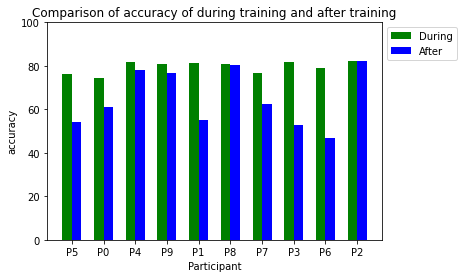

In [76]:
for _ in tqdm(range(args.randomorder_rounds)):
    Upload_list = random.sample(Participant_keys, args.num_participants)
    During_train = []
    After_train = []

    for key in Upload_list:
        print('='*10, key, '='*10)
        vertical_train(TrainData_dict[key], Participant_dict[key], Server, epochs =  1)
        print(f'Participant {key} testing:')
        accuracy = vertical_testing(Participant_dict[key], Server, test_dataset)
        During_train.append(accuracy)

    print('\n======================\n Testing after all participant train')
    for key in Upload_list:
        print(f'Participant {key} testing:')
        accuracy = vertical_testing(Participant_dict[key], Server, test_dataset)
        After_train.append(accuracy)
    width = 0.3
    x = np.arange(len(Upload_list))
    plt.bar(x,During_train,width, color = 'green', label = "During")
    plt.bar(x+width,After_train,width, color = 'blue', label = "After")
    plt.xticks(x + width/2, Upload_list)
    plt.ylim(0,100)

    plt.title("Comparison of accuracy of during training and after training") # title
    plt.ylabel("accuracy") # y label
    plt.xlabel("Participant") # x label
    plt.legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.show()

#Vertical training with 2 participant

In [90]:
def vertical_train_2(set1, set2, Client1, Client2, Server, epochs):
  for e in range(epochs):
    epoch_loss_sum = 0
    for i in range(0,len(set1),1):
      it1 = iter(set1)
      it2 = iter(set2)
      (data_1, label_1) = next(it1)
      (data_2, label_2) = next(it2)
      data_1, label_1 = data_1.to(device), label_1.to(device)
      data_2, label_2 = data_2.to(device), label_2.to(device)
      batch_size = data_1.shape[0]
      data_1 = data_1.view(batch_size,-1)
      data_2 = data_2.view(batch_size,-1)
      # print(data_1.shape,data_2.shape,label_1.shape)
      #forward training
      client_out_1 = Client1.LocalTrain(data_1)
      client_out_2 = Client2.LocalTrain(data_2)
      c_out = torch.cat((client_out_1,client_out_2),-1)
      #print(client_out_1.shape,c_out.shape)
      server_out = Server.ServerTrain(c_out)
      
      #Calculating loss
      server_loss = Server.loss_fn(server_out,label_1)
      client_loss_1 = Server.loss_fn(client_out_1,label_1)
      client_loss_2 = Server.loss_fn(client_out_2,label_2)
      #Server backward
      Server.optimizer.zero_grad()
      server_loss.backward(retain_graph=True)
      Server.optimizer.step()
      #Client backward
      Client1.optimizer.zero_grad()
      client_loss_1.backward(retain_graph=True)
      client_loss_1.retain_grad()
      # print(client_loss_1.grad)
      Client1.optimizer.step()

      Client2.optimizer.zero_grad()
      client_loss_2.backward()
      Client2.optimizer.step()


#Vertical testing with 2 participant

In [82]:
def vertical_testing_2(Client1, Client2 ,Server, test_dataset):
    Client1.local_network.eval()
    Client2.local_network.eval()
    Server.global_network.eval()

    correct = 0
    epoch_loss_sum = 0
    Labels = []
    Predicts = []
    testloss_history = []
    accu_history = []

    with torch.no_grad():
      
        for i in range(0,len(test_dataset),1):
            it1 = iter(test_dataset)
            it2 = iter(test_dataset)
            (data_1, label_1) = next(it1)
            (data_2, label_2) = next(it2)
            data_1, label_1 = data_1.to(device), label_1.to(device)
            data_2, label_2 = data_2.to(device), label_2.to(device)
            batch_size = data_1.shape[0]
            data_1 = data_1.view(batch_size,-1)
            data_2 = data_2.view(batch_size,-1)

            #forward training
            client_out_1 = Client1.LocalTrain(data_1)
            client_out_2 = Client2.LocalTrain(data_2)
            c_out = torch.cat((client_out_1,client_out_2),-1)
            server_out = Server.ServerTrain(c_out)
            
            #Calculating loss
            label = torch.cat((label_1,label_2),-1)
            server_loss = Server.loss_fn(server_out,label_1)
            epoch_loss_sum += float(server_loss.item())

            predict = server_out.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += predict.eq(label_1.data.view_as(predict)).sum().item()
            Labels = Labels + label_1.tolist()
            Predicts = Predicts + predict.tolist()

        epoch_loss_sum /= len(test_dataset.dataset)
        accuracy = 100. * correct / len(test_dataset.dataset)
        testloss_history.append(epoch_loss_sum)
        accu_history.append(accuracy / 100)
        f1 = f1_score(Labels, Predicts, average = "macro")
        print(f'Test set: Average loss: {epoch_loss_sum:.4f}, Accuracy: {correct}/{len(test_dataset.dataset)} ({accuracy:.2f}%), F1-score: {f1:.4f}')
    return accuracy

#2 Participant training

In [83]:
#測試準確率的 test dataset (全部10,000的資料)
test_dataset = data.DataLoader(dataset=test_set, batch_size=args.test_batch_size,shuffle=True)

# Dataset and Participant Gernerate
Participant_dict = GenerateParticipant(args.num_participants)
TrainData_dict, TestData_dict = SplitData(train_set, test_set, args.num_participants)

# Participants keys
Participant_keys = list(Participant_dict.keys())

# Paticipants num
client_num = 2
# global server initialization
Server = GlobalServer(client_num)

  0%|          | 0/1 [00:00<?, ?it/s]


training P2 and P7
========== P2  and  P7 ==========
Participant P2 and P7 testing:
Test set: Average loss: 0.0222, Accuracy: 7793/10000 (77.93%), F1-score: 0.7705

training P9 and P8
========== P9  and  P8 ==========
Participant P9 and P8 testing:
Test set: Average loss: 0.0118, Accuracy: 8516/10000 (85.16%), F1-score: 0.8477

training P1 and P5
========== P1  and  P5 ==========
Participant P1 and P5 testing:
Test set: Average loss: 0.0118, Accuracy: 8638/10000 (86.38%), F1-score: 0.8585

training P6 and P4
========== P6  and  P4 ==========
Participant P6 and P4 testing:
Test set: Average loss: 0.0260, Accuracy: 7576/10000 (75.76%), F1-score: 0.7423

training P3 and P0
========== P3  and  P0 ==========
Participant P3 and P0 testing:
Test set: Average loss: 0.0177, Accuracy: 8317/10000 (83.17%), F1-score: 0.8202

===Testing after every train===

Participant P2 and P7 testing:
Test set: Average loss: 0.0165, Accuracy: 8166/10000 (81.66%), F1-score: 0.8149

Participant P9 and P8 testing

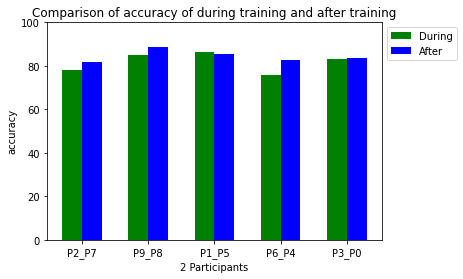

In [91]:
for _ in tqdm(range(args.randomorder_rounds)):
    Upload_list = random.sample(Participant_keys, args.num_participants)
    Client_list = []
    During_train = []
    After_train = []

    for i in range(0,args.num_participants, client_num):
      key1 = Upload_list[i]
      key2 = Upload_list[i+1]
      print(f'\ntraining {key1} and {key2}')
      print('='*10, key1,' and ', key2, '='*10)
      vertical_train_2(TrainData_dict[key1], TrainData_dict[key2], Participant_dict[key1], Participant_dict[key2], Server, 1)
      print(f'Participant {key1} and {key2} testing:')
      accuracy = vertical_testing_2(Participant_dict[key1], Participant_dict[key2], Server, test_dataset)
      dict_key = key1 + "_" + key2
      Client_list.append(dict_key)
      During_train.append(accuracy)

    print('\n===Testing after every train===')
    for i in range(0,args.num_participants, client_num):
      key1 = Upload_list[i]
      key2 = Upload_list[i+1]
      print(f'\nParticipant {key1} and {key2} testing:')
      accuracy = vertical_testing_2(Participant_dict[key1], Participant_dict[key2], Server, test_dataset)
      After_train.append(accuracy)

    width = 0.3
    x = np.arange(len(Client_list))
    plt.bar(x,During_train,width, color = 'green', label = "During")
    plt.bar(x+width,After_train,width, color = 'blue', label = "After")
    plt.xticks(x + width/2, Client_list)
    plt.ylim(0,100)

    plt.title("Comparison of accuracy of during training and after training") # title
    plt.ylabel("accuracy") # y label
    plt.xlabel(str(client_num) + " Participants") # x label
    plt.legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.show()